# EDA of freMTPL Dataset

## Sprawdzenie zasobów

In [1]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

4

In [49]:
!pip install git+https://github.com/krzpiesiewicz/timeseries.git@16a3e149007bbe58207024d153a8bfeb076388ac

  Cloning https://github.com/krzpiesiewicz/timeseries.git (to revision 16a3e149007bbe58207024d153a8bfeb076388ac) to /tmp/pip-req-build-_afm7rxx
  Running command git clone --filter=blob:none --quiet https://github.com/krzpiesiewicz/timeseries.git /tmp/pip-req-build-_afm7rxx
  Running command git rev-parse -q --verify 'sha^16a3e149007bbe58207024d153a8bfeb076388ac'
  Running command git fetch -q https://github.com/krzpiesiewicz/timeseries.git 16a3e149007bbe58207024d153a8bfeb076388ac
  Resolved https://github.com/krzpiesiewicz/timeseries.git to commit 16a3e149007bbe58207024d153a8bfeb076388ac
  Preparing metadata (setup.py) ... done


In [1]:
!pip install git+https://github.com/krzpiesiewicz/concise-analysis.git@edb815abd94720120144e690f04c81db136ac853

  Cloning https://github.com/krzpiesiewicz/concise-analysis.git (to revision edb815abd94720120144e690f04c81db136ac853) to /tmp/pip-req-build-wml_s5i5
  Running command git clone --filter=blob:none --quiet https://github.com/krzpiesiewicz/concise-analysis.git /tmp/pip-req-build-wml_s5i5
  Running command git rev-parse -q --verify 'sha^edb815abd94720120144e690f04c81db136ac853'
  Running command git fetch -q https://github.com/krzpiesiewicz/concise-analysis.git edb815abd94720120144e690f04c81db136ac853
  Running command git checkout -q edb815abd94720120144e690f04c81db136ac853
  Resolved https://github.com/krzpiesiewicz/concise-analysis.git to commit edb815abd94720120144e690f04c81db136ac853
  Preparing metadata (setup.py) ... done
DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a 

In [2]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.3 MB/s eta 0:00:00m eta 0:00:010:01:01
DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns

from concise_analysis.models import (
    ClassificationsCollector,
    RegressionPredictionsCollector,
    collect_ensemble_predictions,
    get_scores,
    get_cv_scores,
    print_scores,
    print_importance,
    forests_importance,
)

from timeseries import plot_ts

## Dane i analiza

In [6]:
import os
os.chdir("..")
!ls

conf  docs	 pyproject.toml  requirements-example.txt  src
data  notebooks  README.md	 requirements.txt	   tests


In [8]:
freq_df = pd.read_csv('data/01_raw/freMTLP2freq.csv')

In [6]:
freq_df.head()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region
0,1.0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
1,3.0,1,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
2,5.0,1,0.75,6,2,52,50,B12,Diesel,B,54,Picardie
3,10.0,1,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine
4,11.0,1,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine


In [7]:
freq_df.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [9]:
missing = False

for col in freq_df.columns:
    nans = np.sum(freq_df[col].isna())
    if nans > 0:
        print(f"{nans} missing values in column {col}")
        missing = True

if not missing:
    print("No missing values")

No missing values


### Odstające wartości zmiennej objaśnianej

In [10]:
n = len(freq_df)
cnts = pd.DataFrame(freq_df.groupby("ClaimNb").ClaimNb.count())
cnts.columns = ["Samples"]
cnts["Percentage"] = round(100 * cnts.Samples / n, 2)
cnts

,Samples,Percentage
ClaimNb,,
0,643953,94.98
1,32178,4.75
2,1784,0.26
3,82,0.01
4,7,0.00
5,2,0.00
6,1,0.00
8,1,0.00
9,1,0.00


In [15]:
freq_df["Freq_TRG"] = freq_df["ClaimNb"] / freq_df["Exposure"]

In [16]:
fig = px.histogram(
    freq_df.Freq_TRG[freq_df.Freq_TRG > 0.0001],
    title="Freq_TRG = ClaimNb / Exposure",
    log_y=True,
    
)
fig.update_traces(opacity=0.75)
fig.show()

In [40]:
from statsmodels.distributions.empirical_distribution import ECDF

pos_freq_cdf = ECDF(freq_df.Freq_TRG[freq_df.Freq_TRG > 1e-7])

In [35]:
idx = [np.where(pos_freq_cdf.y[1:] >= x)[0][0] for x in np.linspace(0, 1, 10001)[1:]]

In [36]:
s = pd.Series(pos_freq_cdf.y[idx], index=pd.Index(pos_freq_cdf.x[idx]))
plot_ts(s, engine="plotly", name="Freq_TRG", title="ECDF")

In [41]:
pos_freq_inv_cdf = pd.Series(pos_freq_cdf.x[idx], index=pd.Index(pos_freq_cdf.y[idx]))

In [43]:
pos_freq_inv_cdf

0.000088      0.666667
0.000176      0.769231
0.000294      0.806452
0.000382      0.813008
0.000499      0.869565
               ...    
0.999589    366.000000
0.999677    366.000000
0.999794    366.000000
0.999883    366.000000
0.999971    732.000000
Length: 10000, dtype: float64

In [52]:
def target_percs(data, only_positive=False, trg_var="Freq_TRG"):
    vals_and_ops = [(0, "≥"), (0, ">"), (1, "≥"), (1, ">")] + list(zip([1.5, 2, 3, 5, 7] + list(range(10, 110, 10)) + [150, 200, 250, 300, 350, 400], [">"] * 100))
    if only_positive:
        vals_and_ops = vals_and_ops[1:]
        data = data[data[trg_var] > 0]
    n = len(data)
    rows = []
    for t, op in vals_and_ops:
        if op == "≥":
            cnt = (data[trg_var] >= t).sum()
        else:
            cnt = (data[trg_var] > t).sum()
        thrhs = f"{trg_var} {op} {t:3}".replace(" ", " ")
        rows.append((thrhs, cnt, round(100 * cnt/n, 2)))
    df = pd.DataFrame(rows, columns=["Threshold", "Samples", "Percentage"])
    return df


target_percs(freq_df)

,Threshold,Samples,Percentage
0,Freq_TRG ≥ 0,678013,100.00
1,Freq_TRG > 0,34060,5.02
2,Freq_TRG ≥ 1,34012,5.02
3,Freq_TRG > 1,23337,3.44
4,Freq_TRG > 1.5,17115,2.52
5,Freq_TRG > 2,12913,1.90
6,Freq_TRG > 3,8958,1.32
7,Freq_TRG > 5,5473,0.81
8,Freq_TRG > 7,4349,0.64
9,Freq_TRG > 10,3106,0.46


In [53]:
target_percs(freq_df, only_positive=True)

,Threshold,Samples,Percentage
0,Freq_TRG > 0,34060,100.00
1,Freq_TRG ≥ 1,34012,99.86
2,Freq_TRG > 1,23337,68.52
3,Freq_TRG > 1.5,17115,50.25
4,Freq_TRG > 2,12913,37.91
5,Freq_TRG > 3,8958,26.30
6,Freq_TRG > 5,5473,16.07
7,Freq_TRG > 7,4349,12.77
8,Freq_TRG > 10,3106,9.12
9,Freq_TRG > 20,1214,3.56


Jak widać powyżej mamy w zbiorze danych obserwacje mocno odstające

## Podział danych na zbiory: treningowy, walidacyjny i testowy

In [15]:
from sklearn.model_selection import train_test_split

train_val_ids, test_ids = train_test_split(
    data["target"],
    test_size=0.3,
    random_state=20230325,
)
train_val_ids = train_val_ids.index
test_ids = test_ids.index
train_val_data = data.loc[train_val_ids]
test_data = data.loc[test_ids]

train_ids, val_ids = train_test_split(
    train_val_data["target"],
    test_size=0.3,
    random_state=20230523,
)

train_ids = train_ids.index
val_ids = val_ids.index
train_data = data.loc[train_ids]
val_data = data.loc[val_ids]

In [16]:
def make_X_y(
    data,
    target,
    selected_ftrs=None,
    dropped_ftrs=None,
):
    y = data[target].copy()

    df = data.filter(selected_ftrs) if selected_ftrs is not None else data
    df = df.copy()

    if dropped_ftrs is not None:
        for ftr in dropped_ftrs:
            if ftr in df.columns:
                df.drop(ftr, axis=1, inplace=True)
    
    X = df.drop(target, axis=1) if target in df.columns else df
    return X, y

## Undersampling zbioru treningowego

In [17]:
target_percs(train_data)

,Threshold,Samples,Percentage
0,target ≥ 0,332226,100.00
1,target > 0,16675,5.02
2,target ≥ 1,16649,5.01
3,target > 1,11440,3.44
4,target > 1.5,8381,2.52
5,target > 2,6350,1.91
6,target > 3,4393,1.32
7,target > 5,2661,0.80
8,target > 7,2132,0.64
9,target > 10,1509,0.45


In [18]:
train_data_zero_trg_mask = (train_data.target == 0)
train_data_zero_ids = train_data[train_data_zero_trg_mask].index
train_data_nonzero_ids = train_data[~train_data_zero_trg_mask].index

zeros_cnt = len(train_data_zero_ids)
nonzeros_cnt = len(train_data_nonzero_ids)

p = 0.1
# smpl_zeros_cnt = int(nonzeros_cnt * (1 - p) / p)
smpl_zeros_cnt = zeros_cnt

rng = np.random.default_rng(111)
smpl_zero_ids = pd.Index(rng.choice(train_data_zero_ids, size=smpl_zeros_cnt, replace=False))

train_data_smpl_ids = pd.Index(rng.permutation(smpl_zero_ids.append(train_data_nonzero_ids)))

In [19]:
target_percs(train_data.loc[train_data_smpl_ids])

,Threshold,Samples,Percentage
0,target ≥ 0,332226,100.00
1,target > 0,16675,5.02
2,target ≥ 1,16649,5.01
3,target > 1,11440,3.44
4,target > 1.5,8381,2.52
5,target > 2,6350,1.91
6,target > 3,4393,1.32
7,target > 5,2661,0.80
8,target > 7,2132,0.64
9,target > 10,1509,0.45


## Transformacja danych i selekcja cech

### Zmienne kategoryczne i one-hot encoding

In [20]:
cat_ftrs = []

for ftr in data.loc[train_data_smpl_ids].columns:
    if data.loc[train_data_smpl_ids][ftr].dtype is np.dtype("O"):
        vals = np.unique(data.loc[train_data_smpl_ids][ftr])
        print(f"Feature:  {ftr:13} –   {len(vals):3} distinct values")
        cat_ftrs.append(ftr)

cat_ftrs = pd.Index(cat_ftrs)

Feature:  VehBrand      –    11 distinct values
Feature:  VehGas        –     2 distinct values
Feature:  Area          –     6 distinct values
Feature:  Region        –    21 distinct values


In [21]:
num_ftrs = data.loc[train_data_smpl_ids].columns.drop(cat_ftrs).drop("target")
num_ftrs

Index(['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density'], dtype='object')

In [22]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(min_frequency=100, drop="if_binary", sparse_output=False)
ohe.fit(data.loc[train_data_smpl_ids, cat_ftrs])
feature_names = ohe.get_feature_names_out(cat_ftrs)


def ohe_transform(data):
    return pd.concat(
        [
            data.drop(cat_ftrs, axis=1),
            pd.DataFrame(
                ohe.transform(data.loc[:, cat_ftrs]),
                columns=feature_names,
                index=data.index,
            ).astype(int),
        ],
        axis=1,
    )


train_data = ohe_transform(data.loc[train_ids])
val_data = ohe_transform(data.loc[val_ids])
test_data = ohe_transform(data.loc[test_ids])

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data.loc[train_data_smpl_ids, num_ftrs])


def scale_transform(data):
    return pd.concat(
        [
            pd.DataFrame(
                scaler.transform(data.loc[:, num_ftrs]),
                columns=scaler.get_feature_names_out(),
                index=data.index
            ),
            data.drop(num_ftrs, axis=1)
        ],
        axis=1,
    )


train_data = scale_transform(train_data)
val_data = scale_transform(val_data)
test_data = scale_transform(test_data)

train_data_smpl = train_data.loc[train_data_smpl_ids]

In [24]:
train_data_smpl.head(10)

,VehPower,VehAge,DrivAge,BonusMalus,Density,target,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,...,Region_Ile-de-France,Region_Languedoc-Roussillon,Region_Limousin,Region_Midi-Pyrenees,Region_Nord-Pas-de-Calais,Region_Pays-de-la-Loire,Region_Picardie,Region_Poitou-Charentes,Region_Provence-Alpes-Cotes-D'Azur,Region_Rhone-Alpes
188847,1.725530,0.874401,-0.744806,2.577486,0.384765,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
234185,0.264619,1.757542,-0.108207,-0.624219,-0.449945,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580598,-0.222352,-0.891881,1.801588,-0.624219,-0.265632,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510972,-1.196292,-1.245138,0.882057,-0.624219,0.004525,0.0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
207652,0.264619,-1.068510,1.164990,-0.624219,0.720316,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
65275,-1.196292,-0.185369,0.599124,-0.624219,-0.353496,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297126,-0.222352,0.167888,-1.027739,-0.240014,0.310030,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
547045,0.751589,1.051029,1.235723,-0.624219,-0.448177,0.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
672530,1.725530,-1.068510,0.952790,-0.624219,0.046185,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
673176,0.751589,-1.068510,0.811324,-0.624219,-0.016178,0.0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


<Axes: >

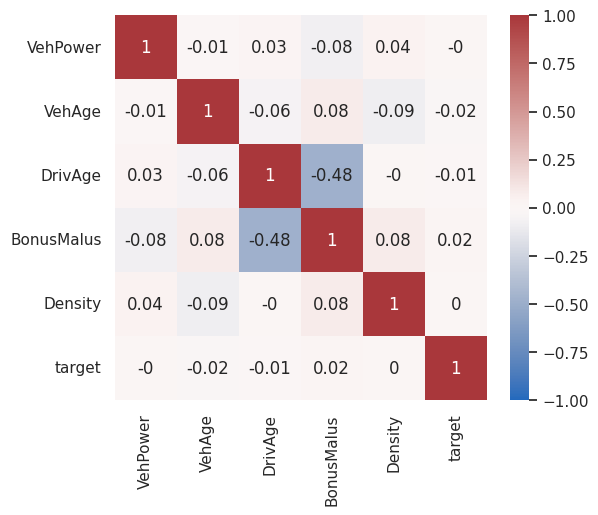

In [25]:
corr_mat = data.loc[train_data_smpl_ids].corr(numeric_only=True).round(2)
sns.set(rc={"figure.figsize": (6, 5)})
fig = sns.heatmap(corr_mat, cmap="vlag", vmin=-1, vmax=1, annot=True)
display(fig)

In [26]:
corr_mat = train_data_smpl.corr(numeric_only=True).round(2)

In [27]:
corr_mat.filter(like="VehBrand", axis=0).filter(like="target", axis=1)

,target
VehBrand_B1,-0.01
VehBrand_B10,-0.00
VehBrand_B11,-0.00
VehBrand_B12,0.03
VehBrand_B13,-0.00
VehBrand_B14,-0.00
VehBrand_B2,-0.01
VehBrand_B3,-0.00
VehBrand_B4,-0.00
VehBrand_B5,-0.00


In [28]:
corr_mat.filter(like="VehGas", axis=0).filter(like="target", axis=1)

,target
VehGas_Regular,0.01


In [29]:
corr_mat.filter(like="Area", axis=0).filter(like="target", axis=1)

,target
Area_A,-0.00
Area_B,-0.00
Area_C,-0.00
Area_D,0.00
Area_E,0.00
Area_F,0.01


In [30]:
corr_mat.filter(like="Region", axis=0).filter(like="target", axis=1)

,target
Region_Alsace,0.00
Region_Aquitaine,-0.00
Region_Auvergne,-0.00
Region_Basse-Normandie,-0.00
Region_Bourgogne,0.00
Region_Bretagne,-0.00
Region_Centre,-0.01
Region_Champagne-Ardenne,0.01
Region_Corse,0.00
Region_Franche-Comte,0.00


In [31]:
counts_non_zeros = train_data_smpl[train_data_smpl > 0.1].count().sort_values(ascending=False)

In [32]:
counts_non_zeros.filter(like="VehBrand")

VehBrand_B12    81516
VehBrand_B1     79770
VehBrand_B2     78227
VehBrand_B3     26037
VehBrand_B5     17130
VehBrand_B6     13920
VehBrand_B4     12418
VehBrand_B10     8658
VehBrand_B11     6602
VehBrand_B13     5959
VehBrand_B14     1989
dtype: int64

In [33]:
counts_non_zeros.filter(like="VehGas")

VehGas_Regular    169738
dtype: int64

In [34]:
counts_non_zeros.filter(like="Area")

Area_C    94307
Area_D    74222
Area_E    67177
Area_A    50904
Area_B    36806
Area_F     8810
dtype: int64

In [35]:
counts_non_zeros.filter(like="Region")

Region_Centre                         78866
Region_Rhone-Alpes                    41476
Region_Provence-Alpes-Cotes-D'Azur    38764
Region_Ile-de-France                  34254
Region_Bretagne                       20632
Region_Nord-Pas-de-Calais             19680
Region_Pays-de-la-Loire               18884
Region_Languedoc-Roussillon           17599
Region_Aquitaine                      15254
Region_Poitou-Charentes                9298
Region_Midi-Pyrenees                   8456
Region_Basse-Normandie                 5339
Region_Bourgogne                       5182
Region_Haute-Normandie                 4312
Region_Picardie                        3936
Region_Auvergne                        2635
Region_Limousin                        2249
Region_Corse                           2175
Region_Champagne-Ardenne               1493
Region_Alsace                          1123
Region_Franche-Comte                    619
dtype: int64

In [36]:
train_select_ids, val_select_ids = train_test_split(
    train_data_smpl["target"],
    test_size=0.3,
    random_state=20230520,
)

train_select_ids = train_select_ids.index
val_select_ids = val_select_ids.index

In [37]:
train_select_data = train_data_smpl.loc[train_select_ids]
val_select_data = train_data_smpl.loc[val_select_ids]

X_select_train, y_select_train = make_X_y(train_select_data, target="target")
X_select_val, y_select_val = make_X_y(val_select_data, target="target")

rng = np.random.default_rng(323424342)
X_select_train["RandomUniform1"] = rng.uniform(-1, 1, len(X_select_train))
X_select_val["RandomUniform1"] = rng.uniform(-1, 1, len(X_select_val))
X_select_train["RandomUniform2"] = rng.uniform(-1, 1, len(X_select_train))
X_select_val["RandomUniform2"] = rng.uniform(-1, 1, len(X_select_val))
X_select_train["RandomNormal1"] = rng.normal(0, 1, len(X_select_train))
X_select_val["RandomNormal1"] = rng.normal(0, 1, len(X_select_val))
X_select_train["RandomNormal2"] = rng.normal(0, 1, len(X_select_train))
X_select_val["RandomNormal2"] = rng.normal(0, 1, len(X_select_val))
X_select_train["RandomBern1"] = rng.choice([0,1], len(X_select_train))
X_select_val["RandomBern1"] = rng.choice([0,1], len(X_select_val))
X_select_train["RandomBern2"] = rng.choice([0,1], len(X_select_train))
X_select_val["RandomBern2"] = rng.choice([0,1], len(X_select_val))

In [38]:
X_select_train

,VehPower,VehAge,DrivAge,BonusMalus,Density,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,...,Region_Picardie,Region_Poitou-Charentes,Region_Provence-Alpes-Cotes-D'Azur,Region_Rhone-Alpes,RandomUniform1,RandomUniform2,RandomNormal1,RandomNormal2,RandomBern1,RandomBern2
506931,-0.709322,-0.891881,-1.098472,0.528395,1.380055,0,0,0,1,0,...,0,0,0,0,-0.903770,0.503906,-0.407398,0.521675,0,0
271618,-1.196292,-0.538625,-1.027739,0.976634,0.330734,1,0,0,0,0,...,0,0,0,1,-0.824791,-0.183178,0.439342,-0.302499,1,0
395825,1.725530,0.874401,-0.178940,-0.624219,-0.256795,0,0,0,1,0,...,0,0,0,0,-0.284612,-0.551617,-0.929668,0.246449,0,0
583298,0.264619,1.580914,0.528391,-0.624219,-0.438583,0,0,0,0,0,...,0,0,0,0,0.124704,0.614601,-0.405897,0.261365,0,0
93801,-0.709322,-1.068510,0.599124,-0.624219,-0.324460,0,0,0,1,0,...,0,0,0,0,-0.633911,-0.328077,0.553864,0.634576,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68007,-1.196292,0.697773,-1.098472,-0.624219,-0.446915,0,0,0,0,0,...,0,0,0,0,0.512311,-0.441430,0.287519,-0.944623,0,0
579800,0.264619,2.110798,-1.310671,2.577486,-0.121211,1,0,0,0,0,...,0,0,0,0,0.128561,-0.501823,1.914213,0.721931,1,0
389017,0.264619,-0.185369,0.103992,-0.624219,-0.205541,1,0,0,0,0,...,0,0,0,0,-0.666736,-0.444841,-2.432422,-0.057901,1,1
10573,-0.222352,0.167888,0.316192,-0.624219,-0.441613,0,0,0,0,0,...,0,0,0,0,0.387171,0.167755,-1.233319,-1.649172,0,1


### Ranking cech według lasu losowego

In [44]:
from sklearn.ensemble import RandomForestRegressor

forest_hparams = dict(
    ccp_alpha=0,
    min_impurity_decrease=0,
    max_depth=10,
    max_features=10,
    n_estimators=400,
    min_samples_leaf=100,
    max_samples=0.5,
    n_jobs=2,
    random_state=538383,
    bootstrap=True,
    oob_score=True,
)

forests = []
select_baseline_scores = get_cv_scores(
    RandomForestRegressor,
    hparams=forest_hparams,
    X=X_select_train, y=y_select_train,
    X_test=X_select_val, y_test=y_select_val,
    classif=False, mape_score=False,
    list_to_save_models=forests, folds=5
)
print_scores(select_baseline_scores, show_stds=True)
names=X_select_train.keys()
importance, importance_stds, indices, names = forests_importance(forests, names=names)
print_importance(importance, importance_stds, indices, names, model_name="Random forest")

train_r2:  0.0151       train_mae:  0.4887       train_mse:  20.1611       train_medae:  0.1775
          ±0.0003                  ±0.0026                  ±0.5241                    ±0.0022

val_r2:    0.0073       val_mae:    0.4908       val_mse:    20.3291       val_medae:    0.1781
          ±0.0009                  ±0.0037                  ±2.1146                    ±0.0022

test_r2:   0.0053       test_mae:   0.5091       test_mse:   26.2706       test_medae:   0.1780
          ±0.0001                  ±0.0015                  ±0.0023                    ±0.0022


Random forest features ranking:
 1. import. 0.226 (std: 0.083)  –  VehAge
 2. import. 0.087 (std: 0.072)  –  RandomNormal2
 3. import. 0.086 (std: 0.081)  –  RandomUniform2
 4. import. 0.084 (std: 0.075)  –  RandomUniform1
 5. import. 0.080 (std: 0.080)  –  Density
 6. import. 0.076 (std: 0.066)  –  RandomNormal1
 7. import. 0.068 (std: 0.063)  –  DrivAge
 8. import. 0.050 (std: 0.051)  –  VehPower
 9. import. 0.048 (st

### Zmniejszenie wysokich wartości zmiennej target

In [40]:
def log_transform(y):
    return np.log(1 + (np.e - 1) * y)


def inv_log_transform(log_1py):
    return (np.exp(log_1py) - 1) / (np.e - 1)

In [105]:
class LogModelWrapper():
    def __init__(self, model, **kwargs):
        self.model = model
    
    def predict(self, X, *args, **kwargs):
        log_1py = self.model.predict(X, *args, **kwargs)
        y = inv_log_transform(log_1py)
        y[y < 0] = 0
        return y

    def fit(self, X, y, *args, **kwargs):
        log_1py = log_transform(y)
        log_1py[log_1py < 0] = 0
        self.model.fit(X, log_1py, *args, **kwargs)

        if hasattr(self.model, "features_importance_") and self.model.features_importance_ is not None:
            self.features_importance_ = self.model.features_importance_
        if hasattr(self.model, "estimators_") and self.model.estimators_ is not None:
            self.estimators_ = self.model.estimators_


def get_log_model_wrapper_constructor(model_constr, **wrapper_kwargs):
    
    def create_model(*args, **kwargs):
        model = model_constr(*args, **kwargs)
        return LogModelWrapper(model, **wrapper_kwargs)

    return create_model

In [42]:
from sklearn.metrics import mean_squared_error

def mse_log(y_true, y_pred):
    return mean_squared_error(log_transform(y_true), log_transform(y_pred))


log_mse_scoring = {
    "name": "log_mse",
    "pred_type": "pred",
    "scoring": mse_log,
    "res_type": float,
}

### Ranking cech według lasu losowego na podstawie zmniejszonych wartości zmiennej target

In [45]:
from sklearn.ensemble import RandomForestRegressor

forest_hparams = dict(
    ccp_alpha=0,
    min_impurity_decrease=0,
    max_depth=10,
    max_features=10,
    n_estimators=400,
    min_samples_leaf=100,
    max_samples=0.5,
    n_jobs=2,
    random_state=538383,
    bootstrap=True,
    oob_score=True,
)

forests = []
select_baseline_scores = get_cv_scores(
    get_log_model_wrapper_constructor(RandomForestRegressor),
#     RandomForestRegressor,
    hparams=forest_hparams,
    X=X_select_train, y=y_select_train,
    X_test=X_select_val, y_test=y_select_val,
    classif=False, mape_score=False, extra_metrics=[log_mse_scoring],
    list_to_save_models=forests, folds=5
)
print_scores(select_baseline_scores, show_stds=True)
names=X_select_train.keys()
importance, importance_stds, indices, names = forests_importance(forests, names=names)
print_importance(importance, importance_stds, indices, names, model_name="Random forest")

train_r2:  -0.0007       train_mae:  0.3065       train_mse:  20.4842       train_medae:  0.0412       train_log_mse:  0.1537
          ±0.0000                  ±0.0015                  ±0.5280                    ±0.0001                      ±0.0006

val_r2:    -0.0011       val_mae:    0.3069       val_mse:    20.4900       val_medae:    0.0412       val_log_mse:    0.1549
          ±0.0002                  ±0.0053                  ±2.1128                    ±0.0001                      ±0.0026

test_r2:   -0.0011       test_mae:   0.3253       test_mse:   26.4389       test_medae:   0.0412       test_log_mse:   0.1588
          ±0.0000                  ±0.0001                  ±0.0005                    ±0.0001                      ±0.0000


Random forest features ranking:
 1. import. 0.317 (std: 0.088)  –  VehAge
 2. import. 0.117 (std: 0.041)  –  BonusMalus
 3. import. 0.085 (std: 0.064)  –  VehGas_Regular
 4. import. 0.067 (std: 0.026)  –  DrivAge
 5. import. 0.066 (std: 0.045)  –

### Wybór cech

Na podstawie drugiego rankingu

In [54]:
ftrs_cnt = 7
print_importance(importance, importance_stds, indices, names, max_ftrs=ftrs_cnt, model_name="Random forest")

Random forest features ranking:
 1. import. 0.317 (std: 0.088)  –  VehAge
 2. import. 0.117 (std: 0.041)  –  BonusMalus
 3. import. 0.085 (std: 0.064)  –  VehGas_Regular
 4. import. 0.067 (std: 0.026)  –  DrivAge
 5. import. 0.066 (std: 0.045)  –  VehBrand_B12
 6. import. 0.064 (std: 0.044)  –  VehPower
 7. import. 0.044 (std: 0.020)  –  Density



In [55]:
selected_ftrs_idx = indices[:ftrs_cnt]
selected_ftrs = names[selected_ftrs_idx]
selected_ftrs

Index(['VehAge', 'BonusMalus', 'VehGas_Regular', 'DrivAge', 'VehBrand_B12',
       'VehPower', 'Density'],
      dtype='object')

## hyperopt

In [96]:
X_train, y_train = make_X_y(train_data, target="target", selected_ftrs=selected_ftrs)
X_val, y_val = make_X_y(val_data, target="target", selected_ftrs=selected_ftrs)
X_test, y_test = make_X_y(test_data, target="target", selected_ftrs=selected_ftrs)

In [75]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
from functools import partial


def objective(
    hparams,
    model_constructor,
    X,
    y,
    X_val,
    y_val,
    get_model_hparams,
    baseline_select_scores=None,
    const_hparams=None,
    hpopt_results=None,
):
    #     warnings.filterwarnings(action="ignore", category=DeprecationWarning)
    if const_hparams is None:
        const_hparams = {}
    model_hparams = get_model_hparams(hparams, const_hparams)
    model = model_constructor(**model_hparams)
    model.fit(X_train, y_train)
    scores = get_scores(model, X_train, y_train,
                        X_val=X_val, y_val=y_val,
                        classif=False,
                        metrics = ["mae", "mse", "medae"],
                        extra_metrics=[log_mse_scoring])
    loss = scores["val"]["mae"]
    str_buffer = print_scores(
        scores, baseline_select_scores, return_str=True
    )
    str_buffer += f"loss: {loss:.5}, hparams: {hparams}\n"
    str_buffer += "_" * 100 + "\n"
    print(str_buffer)
    if hpopt_results is not None:
        hpopt_results.append(
            (
                loss,
                scores["val"]["mse"],
                scores["val"]["mae"],
                scores,
                hparams.copy(),
            )
        )
    return {"loss": loss, "status": STATUS_OK}

## Las losowy jako podstawowy punkt odniesienia

In [76]:
from sklearn.ensemble import RandomForestRegressor

forest_hparams = dict(
    ccp_alpha=0,
    min_impurity_decrease=0,
    max_depth=10,
    n_estimators=100,
    min_samples_leaf=100,
    max_samples=0.5,
    n_jobs=2,
    random_state=538383,
    bootstrap=True,
    oob_score=True,
)

forest = LogModelWrapper(RandomForestRegressor(**forest_hparams))
forest.fit(X_train, y_train)

select_baseline_scores = get_scores(
    forest,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    classif=False,
    metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring]
)
print_scores(select_baseline_scores)

train_mae:  0.3114       train_mse:  22.2389       train_medae:  0.0400       train_log_mse:  0.1528

val_mae:    0.3182       val_mse:    28.2322       val_medae:    0.0401       val_log_mse:    0.1536




### Strojenie hiperparametrów lasu losowego

In [57]:
def get_random_forest_hparams(hparams, const_hparams):
    dct = dict(**const_hparams)

    if "criterion" in hparams:
        dct["criterion"] = hparams["criterion"]

    if "max_depth" in hparams:
        dct["max_depth"] = int(hparams["max_depth"])

    if "max_features" in hparams:
        dct["max_features"] = int(hparams["max_features"])

    if "min_samples_leaf" in hparams:
        dct["min_samples_leaf"] = int(hparams["min_samples_leaf"])

    if "min_impurity_decrease" in hparams:
        dct["min_impurity_decrease"] = hparams["min_impurity_decrease"]

    if "ccp_alpha" in hparams:
        dct["ccp_alpha"] = hparams["ccp_alpha"]

    if "max_samples" in hparams:
        dct["max_samples"] = hparams["max_samples"]

    if "n_estimators" in hparams:
        dct["n_estimators"] = int(hparams["n_estimators"])

    if "n_jobs" in hparams:
        dct["n_jobs"] = int(hparams["n_jobs"])

    if "random_state" in hparams:
        dct["random_state"] = hparams["random_state"]

    if "bootstrap" in hparams:
        dct["bootstrap"] = hparams["bootstrap"]

    if "oob_score" in hparams:
        dct["oob_score"] = hparams["oob_score"]

    return dct

In [ ]:
forest_space = {
    # "ccp_alpha": hp.quniform("ccp_alpha", 0, 0.01, 0.001),
    # "min_impurity_decrease": hp.quniform("min_impurity_decrease", 0, 0.01, 0.001),
    "max_depth": hp.quniform("max_depth", 2, 20, 1),
    "min_samples_leaf": hp.quniform("min_samples_leaf", 30, 150, 10),
    "max_samples": hp.quniform("max_samples", 0.1, 0.9, 0.1),
}

const_forest_hparams = dict(
    ccp_alpha=0,
    min_impurity_decrease=0,
    n_estimators=100,
    n_jobs=2,
    random_state=538383,
)

hpopt_forest_results = []
trials = Trials()
random_forest_objective = partial(
    objective,
    model_constructor=get_log_model_wrapper_constructor(RandomForestRegressor),
    X=X_train,
    y=y_train,
    X_val=X_val,
    y_val=y_val,
    get_model_hparams=get_random_forest_hparams,
    baseline_select_scores=select_baseline_scores,
    const_hparams=const_forest_hparams,
    hpopt_results=hpopt_forest_results
)
fmin(fn=random_forest_objective, space=forest_space, algo=tpe.suggest, max_evals=100, trials=trials)

hpopt_forest_results = sorted(hpopt_forest_results, key=lambda t: (t[0], t[1], t[2]))
forest_best_hparams = hpopt_forest_results[0][4]


print("Best: ", forest_best_hparams)

In [ ]:
forest_best_hparams

In [ ]:
forest_hparams = get_random_forest_hparams(forest_best_hparams, const_forest_hparams)

forest = LogModelWrapper(RandomForestRegressor(**forest_hparams))
forest.fit(X_train, y_train)

best_forest_scores = get_scores(
    forest,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test = y_test,
    classif=False,
    metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring]
)
print_scores(best_forest_scores, baseline_scores=select_baseline_scores)

## AdaBoost

In [77]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [79]:
def get_adaboost_wrapper_constructor(estim_constr):
    
    def create_model(
        *args,
        n_estimators=50,
        learning_rate=1.0,
        loss="linear",
        random_state=None,
        **kwargs
    ):
        model = estim_constr(*args, **kwargs)
        return AdaBoostRegressor(
            model,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            loss=loss,
            random_state=random_state
        )

    return create_model

In [ ]:
# adaboost_params = dict(
#     n_estimators=50,
#     learning_rate=1.0,
#     loss="linear",
#     random_state=None
# )

# AdaBoost = get_log_model_wrapper_constructor(get_adaboost_wrapper_constructor(DecisionTreeRegressor))

# adaboost_scores = get_cv_scores(
#     AdaBoost,
#     get_random_forest_hparams(adaboost_best_hparams, const_adaboost_hparams),
#     X_train,
#     y_train,
#     X_test=X_val,
#     y_test=y_val,
#     folds=2,
#     classif=False,
#     metrics = ["mae", "mse", "medae"],
#     extra_metrics=[log_mse_scoring]
# )
# print_scores(adaboost_scores, select_baseline_scores, show_stds=True, space=2)




In [81]:
def get_adaboost_hparams(hparams, const_hparams):
    dct = dict(**const_hparams)

    if "n_estimators" in hparams:
        dct["n_estimators"] = int(hparams["n_estimators"])
        
    if "loss" in hparams:
        dct["loss"] = hparams["loss"]

    if "random_state" in hparams:
        dct["random_state"] = hparams["random_state"]

    return dct


adaboost_const_hparams = dict(
    random_state=43131
)

adaboost_space = {
    "n_estimators": hp.quniform("n_estimators", 10, 200, 5),
    "loss": hp.choice("loss", ["linear", "square"]),
    "learning_rate": hp.quniform("learning_rate", 0.001, 1.5, 0.1),
}

AdaBoost = get_adaboost_wrapper_constructor(DecisionTreeRegressor)

hpopt_adaboost_results = []
trials = Trials()
adaboost_objective = partial(
    objective,
    model_constructor=get_log_model_wrapper_constructor(AdaBoost),
    X=X_train,
    y=y_train,
    X_val=X_val,
    y_val=y_val,
    get_model_hparams=get_adaboost_hparams,
    baseline_select_scores=select_baseline_scores,
    const_hparams=adaboost_const_hparams,
    hpopt_results=hpopt_adaboost_results
)
fmin(fn=adaboost_objective, space=adaboost_space, algo=tpe.suggest, max_evals=2, trials=trials)

hpopt_adaboost_results = sorted(hpopt_adaboost_results, key=lambda t: (t[0], t[1], t[2]))
adaboost_best_hparams = hpopt_adaboost_results[0][4]


print("Best: ", adaboost_best_hparams)

train_mae:  0.0820 (-0.2293)       train_mse:  8.1480 (-14.0909)       train_medae:  0.0000 (-0.0400)       train_log_mse:  0.0163 (-0.1365)                                                                                                                                                                                

val_mae:    0.3388 (+0.0206)       val_mse:    32.4582 (+4.2260)       val_medae:    0.0000 (-0.0401)       val_log_mse:    0.1836 (+0.0300)

loss: 0.33875, hparams: {'learning_rate': 0.11, 'loss': 'exponential', 'n_estimators': 45.0}
____________________________________________________________________________________________________

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 1/2 [02:14<02:14, 134.06s/trial, best loss: 0.33875011247964565]


KeyboardInterrupt: 

In [82]:
adaboost_hparams = get_adaboost_hparams(adaboost_best_hparams, adaboost_const_params)
adaboost = AdaBoost(**adaboost_hparams)
adaboost.fit(X_train, y_train)

adaboost_scores = get_scores(
    adaboost,
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    classif=False,
    metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring]
)
print_scores(adaboost_scores, select_baseline_scores, space=2)

KeyboardInterrupt: 

## Gradient Boosting

In [90]:
from sklearn.ensemble import GradientBoostingRegressor


def get_gradient_boosting_hparams(hparams, const_hparams):
    dct = dict(**const_hparams)
    
    if "loss" in hparams:
        dct["loss"] = hparams["loss"]
        
    if "learning_rate" in hparams:
        dct["learning_rate"] = hparams["learning_rate"]

    if "criterion" in hparams:
        dct["criterion"] = hparams["criterion"]

    if "max_depth" in hparams:
        dct["max_depth"] = int(hparams["max_depth"])

    if "max_features" in hparams:
        dct["max_features"] = int(hparams["max_features"])

    if "min_samples_leaf" in hparams:
        dct["min_samples_leaf"] = int(hparams["min_samples_leaf"])

    if "min_impurity_decrease" in hparams:
        dct["min_impurity_decrease"] = hparams["min_impurity_decrease"]

    if "ccp_alpha" in hparams:
        dct["ccp_alpha"] = hparams["ccp_alpha"]

    if "subsample" in hparams:
        dct["subsample"] = hparams["subsample"]

    if "n_estimators" in hparams:
        dct["n_estimators"] = int(hparams["n_estimators"])

    if "random_state" in hparams:
        dct["random_state"] = hparams["random_state"]

    return dct

In [91]:
gradient_boosting_space = {
    "n_estimators": hp.quniform("n_estimators", 10, 200, 5),
    "learning_rate": hp.quniform("learning_rate", 0.001, 0.2, 0.01),
    # "ccp_alpha": hp.quniform("ccp_alpha", 0, 0.01, 0.001),
    # "min_impurity_decrease": hp.quniform("min_impurity_decrease", 0, 0.01, 0.001),
    "max_depth": hp.quniform("max_depth", 2, 10, 1),
    "min_samples_leaf": hp.quniform("min_samples_leaf", 30, 150, 10),
    "subsample": hp.quniform("subsample", 0.1, 0.9, 0.1),
}

gradient_boosting_const_hparams = dict(
    loss="squared_error",
    ccp_alpha=0,
    min_impurity_decrease=0,
    n_iter_no_change=10,
    tol=1e-4,
    random_state=538383,
)

hpopt_gradient_boosting_results = []
trials = Trials()
gradient_boosting_objective = partial(
    objective,
    model_constructor=get_log_model_wrapper_constructor(GradientBoostingRegressor),
    X=X_train,
    y=y_train,
    X_val=X_val,
    y_val=y_val,
    get_model_hparams=get_gradient_boosting_hparams,
    baseline_select_scores=select_baseline_scores,
    const_hparams=gradient_boosting_const_hparams,
    hpopt_results=hpopt_gradient_boosting_results
)
fmin(fn=gradient_boosting_objective, space=gradient_boosting_space, algo=tpe.suggest, max_evals=100, trials=trials)

hpopt_gradient_boosting_results = sorted(hpopt_gradient_boosting_results, key=lambda t: (t[0], t[1], t[2]))
gradient_boosting_best_hparams = hpopt_gradient_boosting_results[0][4]


print("Best: ", gradient_boosting_best_hparams)

train_mae:  0.3118 (+0.0004)       train_mse:  22.2626 (+0.0238)       train_medae:  0.0399 (=0.0000)       train_log_mse:  0.1548 (+0.0020)                                                                                                                                                                                

val_mae:    0.3185 (+0.0004)       val_mse:    28.2584 (+0.0262)       val_medae:    0.0399 (-0.0002)       val_log_mse:    0.1552 (+0.0016)

loss: 0.31852, hparams: {'learning_rate': 0.12, 'max_depth': 4.0, 'min_samples_leaf': 70.0, 'n_estimators': 70.0, 'subsample': 0.4}
____________________________________________________________________________________________________

train_mae:  0.3125 (+0.0011)       train_mse:  22.2774 (+0.0385)       train_medae:  0.0402 (+0.0003)       train_log_mse:  0.1566 (+0.0038)                                                                                                                                                                      

KeyboardInterrupt: 

In [ ]:
gradient_boosting_best_hparams

In [92]:
gradient_boosting_best_hparams = {'learning_rate': 0.06, 'max_depth': 7.0, 'min_samples_leaf': 130.0, 'n_estimators': 145.0, 'subsample': 0.8}

In [97]:
gradient_boosting_hparams = get_gradient_boosting_hparams(gradient_boosting_best_hparams, gradient_boosting_const_hparams)

gradient_boosting = LogModelWrapper(GradientBoostingRegressor(**gradient_boosting_hparams))
gradient_boosting.fit(X_train, y_train)

best_gradient_boosting_scores = get_scores(
    gradient_boosting,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test = y_test,
    classif=False,
    metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring]
)
print_scores(best_gradient_boosting_scores, baseline_scores=select_baseline_scores)

train_mae:  0.3110 (-0.0003)       train_mse:  22.2424 (+0.0035)       train_medae:  0.0394 (-0.0006)       train_log_mse:  0.1526 (-0.0002)

val_mae:    0.3179 (-0.0003)       val_mse:    28.2388 (+0.0066)       val_medae:    0.0395 (-0.0006)       val_log_mse:    0.1537 (=0.0000)

test_mae:   0.2884       test_mse:   14.2217       test_medae:   0.0395       test_log_mse:   0.1521




## xgboost

In [103]:
import xgboost as xgb


def get_xgboost_hparams(hparams, const_hparams):
    dct = dict(**const_hparams)
    
    if "eval_metric" in hparams:
        dct["eval_metric"] = hparams["eval_metric"]
        
    if "learning_rate" in hparams:
        dct["learning_rate"] = hparams["learning_rate"]

    if "objective" in hparams:
        dct["objective"] = hparams["objective"]
        
    if "gamma" in hparams:
        dct["gamma"] = hparams["gamma"]

    if "max_depth" in hparams:
        dct["max_depth"] = int(hparams["max_depth"])

    if "min_child_weight" in hparams:
        dct["min_child_weight"] = int(hparams["min_child_weight"])

    if "colsample_bytree" in hparams:
        dct["colsample_bytree"] = hparams["colsample_bytree"]

    if "subsample" in hparams:
        dct["subsample"] = hparams["subsample"]

    if "n_estimators" in hparams:
        dct["n_estimators"] = int(hparams["n_estimators"])

    if "seed" in hparams:
        dct["seed"] = hparams["seed"]

    return dct

In [106]:
xgboost_space = {
    'max_depth' : hp.quniform("max_depth", 2, 11, 1),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.quniform('n_estimators', 20, 205, 20),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)
}

xgboost_const_hparams = dict(
    eval_metric="rmse",
    objective="reg:squarederror",
    seed=538383,
)

hpopt_xgboost_results = []
trials = Trials()
xgboost_objective = partial(
    objective,
    model_constructor=get_log_model_wrapper_constructor(xgb.XGBRegressor),
    X=X_train,
    y=y_train,
    X_val=X_val,
    y_val=y_val,
    get_model_hparams=get_xgboost_hparams,
    baseline_select_scores=select_baseline_scores,
    const_hparams=xgboost_const_hparams,
    hpopt_results=hpopt_xgboost_results
)
fmin(fn=xgboost_objective, space=xgboost_space, algo=tpe.suggest, max_evals=100, trials=trials)

hpopt_xgboost_results = sorted(hpopt_xgboost_results, key=lambda t: (t[0], t[1], t[2]))
xgboost_best_hparams = hpopt_xgboost_results[0][4]


print("Best: ", xgboost_best_hparams)

train_mae:  0.3133 (+0.0019)       train_mse:  22.2769 (+0.0381)       train_medae:  0.0405 (+0.0005)       train_log_mse:  0.1567 (+0.0039)                                                                                                                                                                                

val_mae:    0.3199 (+0.0018)       val_mse:    28.2752 (+0.0429)       val_medae:    0.0405 (+0.0004)       val_log_mse:    0.1571 (+0.0034)

loss: 0.31991, hparams: {'colsample_bytree': 0.93, 'criterion': 'entropy', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 2.0, 'min_child_weight': 5.0, 'n_estimators': 60.0, 'subsample': 0.21}
____________________________________________________________________________________________________

train_mae:  0.3114 (=0.0000)       train_mse:  22.2612 (+0.0224)       train_medae:  0.0399 (=0.0000)       train_log_mse:  0.1547 (+0.0019)                                                                                                      

train_mae:  0.3118 (+0.0004)       train_mse:  22.2516 (+0.0128)       train_medae:  0.0399 (=0.0000)       train_log_mse:  0.1540 (+0.0012)                                                                                                                                                                                

val_mae:    0.3189 (+0.0008)       val_mse:    28.2574 (+0.0251)       val_medae:    0.0401 (=0.0000)       val_log_mse:    0.1556 (+0.0020)

loss: 0.31895, hparams: {'colsample_bytree': 0.84, 'criterion': 'entropy', 'gamma': 0.46, 'learning_rate': 0.31, 'max_depth': 3.0, 'min_child_weight': 2.0, 'n_estimators': 180.0, 'subsample': 0.39}
____________________________________________________________________________________________________

train_mae:  0.3045 (-0.0069)       train_mse:  21.8285 (-0.4104)       train_medae:  0.0347 (-0.0052)       train_log_mse:  0.1351 (-0.0176)                                                                                                    

train_mae:  0.3026 (-0.0087)       train_mse:  21.9592 (-0.2796)       train_medae:  0.0356 (-0.0044)       train_log_mse:  0.1322 (-0.0206)                                                                                                                                                                                

val_mae:    0.3183 (+0.0001)       val_mse:    28.2013 (-0.0310)       val_medae:    0.0366 (-0.0034)       val_log_mse:    0.1540 (+0.0003)

loss: 0.31829, hparams: {'colsample_bytree': 0.99, 'criterion': 'entropy', 'gamma': 0.27, 'learning_rate': 0.14, 'max_depth': 9.0, 'min_child_weight': 10.0, 'n_estimators': 200.0, 'subsample': 0.76}
____________________________________________________________________________________________________

 23%|████████████████████████████████████████████████████████                                                                                                                                                                                  

KeyboardInterrupt: 

In [ ]:
xgboost_best_hparams

In [109]:
xgboost_best_hparams = {'colsample_bytree': 0.85, 'gamma': 0.28, 'learning_rate': 0.14, 'max_depth': 6.0, 'min_child_weight': 8.0, 'n_estimators': 200.0, 'subsample': 0.7000000000000001}

In [110]:
xgboost_hparams = get_random_forest_hparams(xgboost_best_hparams, xgboost_const_hparams)

xgboost_model = LogModelWrapper(xgb.XGBRegressor(**xgboost_hparams))
xgboost_model.fit(X_train, y_train)

best_xgboost_scores = get_scores(
    xgboost_model,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test = y_test,
    classif=False,
    metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring]
)
print_scores(best_xgboost_scores, baseline_scores=select_baseline_scores)

train_mae:  0.3044 (-0.0070)       train_mse:  21.9452 (-0.2937)       train_medae:  0.0371 (-0.0029)       train_log_mse:  0.1378 (-0.0150)

val_mae:    0.3190 (+0.0008)       val_mse:    28.2184 (-0.0139)       val_medae:    0.0377 (-0.0024)       val_log_mse:    0.1549 (+0.0013)

test_mae:   0.2897       test_mse:   14.2084       test_medae:   0.0377       test_log_mse:   0.1535




## Ewaluacja modeli